In [1]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
#import tensorflow_addons as tfa
from IPython.display import clear_output
import matplotlib.pyplot as plt


physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Proximal Policy Optimization

PPO is a policy gradient Actor-Critic algorithm. The policy model, the **actor** network  produces a stochastic policy. It maps the state to a probability distribution over the set of possible actions. The **critic** network is used to approximate the value function and then, the advantage is calculated:

$$
A_\Phi (s_t, a_t) = q_\Phi (s_t,a_t) - v_\Phi (s_t) = R_t + \gamma v_{\Phi'} (s_{t+1}) - v_\Phi (s_t)
$$

The critic, $v_\Phi$ is trained in the same manner, as the DQN model and the critic of DDPG, with TD-learning and a "frozen" and periodically updated target critic network, $v_{\Phi'}$. Instead of approximating a q-value, it approximates the value.

To train the actor, PPO uses the ratio of two policies:
- a current policy $\pi_\Theta$, that is learned currently
- a baseline policy $\pi_{\Theta´}$, an earlier version of the policy

$$
r^t (\Theta)=r_\Theta (s_t,a_t) = \frac{\pi_\Theta (a_t | s_t)}{\pi_{\Theta'} (a_t | s_t)}
$$

It is the ratio of the probabilities of selecting $a_t$ given $\pi_\Theta$ and the probability of selecting the same action with $\pi_{\Theta´}$.

When multiplied with the the approximated advantage, calculated using the critic network, it can be used as the objective function (maximize with SGA)

$$
loss_{actor} = - r_\Theta (s_t, a_t) A_\Phi (s_t, a_t)
$$

as when
- the advantage is positive, meaning, that selecting the action would increase the value, the probability of selecting this action would increase
- the advantage is negative, meaning, that selecting the action would decrease the value, the probability of selecting this action would decrease

Instead of using this directly as loss function, to stabilize the implementation by adjusting the policy optimization step size, the loss is extended in a pessimistic way:

$$
loss_{actor} = \min [r_\Theta (s_t, a_t) A_\Phi (s_t, a_t), clip(r_\Theta (s_t, a_t), 1-\epsilon, 1+\epsilon) A_\Phi (s_t, a_t)]
$$

PPO uses 2 main models. The actor network learns the stochastic policy. It maps the state to a probability distribution over the set of possible actions. The critic network learns the value function. It maps the state to a scalar.

The critic, $v_\Phi$ is trained in the same manner, as the DQN model and the critic of DDPG, with TD-learning and a "frozen" and periodically updated target critic network, $v_{\Phi'}$. Instead of approximating a q-value, it approximates the value.

To train the actor, PPO uses the ratio of two policies:
- a current policy $\pi_\Theta$, that is learned currently
- a baseline policy $\pi_{\Theta´}$, an earlier version of the policy

$$
r^t (\Theta)=r_\Theta (s_t,a_t) = \frac{\pi_\Theta (a_t | s_t)}{\pi_{\Theta'} (a_t | s_t)}
$$

It is the ratio of the probabilities of selecting $a_t$ given $\pi_\Theta$ and the probability of selecting the same action with $\pi_{\Theta´}$.

When multiplied with the the approximated advantage, calculated using the critic network, it can be used as the objective function (maximize with SGA)

$$
loss_{actor} = - r_\Theta (s_t, a_t) A_\Phi (s_t, a_t)
$$

as when
- the advantage is positive, meaning, that selecting the action would increase the value, the probability of selecting this action would increase
- the advantage is negative, meaning, that selecting the action would decrease the value, the probability of selecting this action would decrease

Instead of using this directly as loss function, to stabilize the implementation by adjusting the policy optimization step size, the loss is extended in a pessimistic way:

$$
loss_{actor} = \min [r_\Theta (s_t, a_t) A_\Phi (s_t, a_t), clip(r_\Theta (s_t, a_t), 1-\epsilon, 1+\epsilon) A_\Phi (s_t, a_t)]
$$

In [2]:
class Actor(tf.keras.layers.Layer):
    def __init__(self, units=(400, 300), n_actions=2, **kwargs):
        super(Actor, self).__init__(**kwargs)
        self.layers = []
        for i, u in enumerate(units):
            self.layers.append(tf.keras.layers.Dense(u, activation='relu'))
        self.layers.append(tf.keras.layers.Dense(n_actions, activation='softmax'))
        
    def call(self, inputs, **kwargs):
        outputs = inputs
        for l in self.layers:
            outputs = l(outputs)
        return outputs  #Anzahl der Actions -> Wahrschinlichkeitsverteilung
    
class Critic(tf.keras.layers.Layer):
    def __init__(self, units=(400, 300), **kwargs):
        super(Critic, self).__init__(**kwargs)
        self.layers = []
        for i, u in enumerate(units):
            self.layers.append(tf.keras.layers.Dense(u, activation='relu'))
        self.layers.append(tf.keras.layers.Dense(1))
        
    def call(self, inputs, **kwargs):
        outputs = inputs
        for l in self.layers:
            outputs = l(outputs)
        return outputs  #value des aktuellen states
    
class PPOAgent:
    def __init__(self, action_space, observation_space, gamma=0.99, epsilon = 0.2):
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_space = action_space    #added for passing value to act method
        self.observation_shape = observation_space.shape[0]
        self.actor = Actor(n_actions=action_space.n)
        self.actor_old = Actor(n_actions=action_space.n)
        self.critic = Critic()
        self.target_critic = Critic()
        
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00025)#learning_rate=0.00025
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
        
    def _init_networks(self):

        rand = np.random.rand(1,self.observation_shape)  #generate random normalized numbers (sum = 1, shape = (1,obs_shape))
        normalized_rand = rand/np.sum(rand)

        initializer_critic = np.zeros([1, self.observation_shape])
        # initializer_actor = np.zeros([1, self.observation_shape]) #random.rand
        initializer_actor = normalized_rand

        test = self.actor(initializer_actor)
        #print('initial_probs', test)
        self.actor_old(initializer_actor)
        
        self.critic(initializer_critic)
        self.target_critic(initializer_critic)
        
        self.update_frozen_nets()   #after each 10 episodes (like calc_current_avg)
        
    def act(self, observation):
        probs = self.actor(observation).numpy() #converts observation to np.array
        probs = np.squeeze(probs)   #squeezes probs (stochastic policy!!!) to the dataformat passed to np.random -> probs for action:  [[0.3276569  0.3381462  0.33419695]] probs for action squeezed:  [0.3276569  0.3381462  0.33419695]
        #print('probs for action squeezed: ', probs)
        action = np.random.choice(self.action_space.n, p=probs)  #do action with given policy from last episode (explore/ exploit with actor NN)
        #print('choosen action: ', action)
        return action
    
    def get_critic_grads(self, states, next_states, dones, rewards): # similar to dqn
        with tf.GradientTape() as tape: # TensorFlow API that is used for automatic differentiation, computing the derivatives of a function with respect to its inputs
            # namechange is active for the following block

            next_value = self.target_critic(next_states)
            q_value = rewards + (1-dones) * self.gamma * next_value #1-dones, damit letzter value = 0 wird (gibt ja kein Folgezustand mehr)
            value = self.critic(states) #value, next_value, q-value, advantage are tf.Tensors: shape=(batchsize bzw. samples in this episode, 1), dtype=float32

            # calc advantage
            advantage = q_value - value # Maß dafür, wie gut die actions in dieser episode (q-value) waren, im Vergleich zu den erwarteten values (die implizit aus der policy hervorgehen?)
            # adv > 0: actions besser als erwartet -> actor network/ policy sollte mit der expericnce aus der episode angepasst werden!
            advantage = (advantage - tf.reduce_mean(advantage)) / (tf.keras.backend.std(advantage) + 1e-8)  # effectively standardizing the values to have a mean of 0 and a standard deviation of 1
            # Loss and optimisation of critic network with NOT standardized average
            # Reduces input_tensor along the dimensions given in axis by computing the mean of elements across the dimensions in axis
            loss = tf.reduce_mean(tf.square(advantage)) #MSE, datatype tf.Tensor(6.919476, shape=(), dtype=float32 -> 1 loss calculation for each episode
            
        gradients = tape.gradient(loss, self.critic.trainable_variables)    #calc updated weights for online critic
        gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients]  
        return gradients, loss, advantage
    
    def get_actor_grads(self, states, actions, advantage):  #calc probs of baseline and actual policy -> calc ratio
        with tf.GradientTape() as tape:
            
            # calc stochastic policy (W-Verteilung über alle actions -> ges. = 1) with critic and critic_old -> updated every %x episodes
            p_current = tf.gather(self.actor(states), actions, axis=1)  #tf.gather wird verwendet, um die Wahrscheinlichkeiten der ausgewählten Aktionen (actions) aus der berechneten Policy zu extrahieren.
            p_old = tf.gather(self.actor_old(states), actions, axis=1)  #p_current and p_old are tf.tensor datatypes
            # p_old, p_current are tf.tensors shape(batch_size x batch_size) -> rows: states during exploration (batch-size), collumns: actions taken from this state with given probability
            # one row: one episode with batch_size steps, selected probability for the actions_vector
            
            # calculate ratio -> factor to evaluate if the current policy optimisation was better (>1) or worse (<1) as the old before update the frozen NN actor old
            ratio = p_current / p_old

            # do clipping of ratio
            clip_ratio = tf.clip_by_value(ratio, 1-self.epsilon, 1+self.epsilon)
            objective = ratio * advantage   #(batchsize x batchsize) = (batchsize x batchsize) * (batchsize, 1) -> rowwise multiplication
            clip_objective = clip_ratio * advantage

            # calculate loss to optimize actor NN (und damit auch stochastic policy)
            policy_loss = -tf.reduce_mean(tf.where(objective < clip_objective, objective, clip_objective)) # tf.where: conditional element-wise selection on passed condition
            # - to be consistent with the convention in optimization problems, where the objective is typically minimized, but in this case, you are maximizing a negated version of the mean

            # ***********************Added Entropy for more diverse Exploration************************* -> penalizes not diverse actions
            entropy = -tf.reduce_sum(p_current * tf.math.log(p_current + 1e-10), axis=1, keepdims=True)
            entropy_loss = -0.01 * tf.reduce_mean(entropy)  # Adjust the coefficient as needed
            total_loss = policy_loss + entropy_loss
        gradients = tape.gradient(total_loss, self.actor.trainable_variables) # loss derivated by trainable_variables -> in our case weights phi -> get gradient!

        # clip gradients 
        gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients]   # hat normalerweise keinen einfluss da Grads kleiner
        return gradients, policy_loss
        

    def learn(self, states, actions, rewards, next_states, dones):
        # process the networks with ganied experience in one episode
        critic_grads, critic_loss, advantage = self.get_critic_grads(states, next_states, dones, rewards)    #process the networks and calculate losses
        actor_grads, actor_loss = self.get_actor_grads(states, actions, advantage)  #outputs are arrays! -> one row per step in enviroment during episode experience gathering
        
        # optimize actor and critic (current!) with calculated loss (bzw. loss schon auf gradients angewendet -> siehe get_grads methoden) with apply:grads method from adams optimizer
        # zip: erzeugt Tupel, die aus einem Gradienten und der entsprechenden trainierbaren Variable bestehen --> hier Liste davon, für jedes Gewicht ein Tupel
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))   # update weights with every call (only online nets!) // backpropagation
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))  # adam optimizer is used, see above
        
        return actor_loss, critic_loss
    
    def update_frozen_nets(self):   # after each 50 episodes see below
# TODO: set discount factor --> muss das überhaupt umgesetzt werden?
        weights = self.actor.get_weights()
        self.actor_old.set_weights(weights)
        weights = self.critic.get_weights()
        self.target_critic.set_weights(weights)

## Training

PPO is an on-policy method. We allways complete a full episode, record the trajectory and the rewards. We then use these to update our network. 

In [3]:
def compute_avg_return(env, agent, num_episodes=1, max_steps=200, render=True):
    total_return = 0.0
    for _ in range(num_episodes):
        obs, _ = env.reset()
        episode_return = 0.0
        done = False
        steps = 0
        while not (done or steps > max_steps):
            if render:
                clear_output(wait=True)
                plt.axis('off')
                plt.imshow(env.render())
                plt.show()
            action = agent.act(np.array([obs]))
            obs, r, termination, truncation, _ = env.step(action)
            if termination or truncation:
                done = True
                
            episode_return += r
            steps += 1
        total_return += episode_return

    return total_return / num_episodes

In [4]:
env = gym.make('CartPole-v1', render_mode = 'human')

agent = PPOAgent(env.action_space, env.observation_space)   #set up the agent (and both NN)

agent._init_networks()

for i in range(501):   #one cycle = one episode -> collecting experience till termination and update NN with gathered experience
    obs, _ = env.reset()    #reset enviroment -> start new episode
    done = False
    
    # init empty lists for storing experience for one episode
    states = []
    rewards = []
    actions = []
    next_states = []
    dones = []
    
    # steps = 0
    while not done: #collect experience in episode
        
        action = agent.act(np.array([obs])) # select action at from current state st by the current policy pi (in this episode!)
        #print('obs', obs)
        new_obs, r, termination, truncation, info = env.step(action)   # get new state st+1 (after action st)

        env.render()

        if termination or truncation:
            done = True
            
        states.append(obs)
        rewards.append([r])
        actions.append(action)
        obs = new_obs
        next_states.append(obs)
        dones.append([done])    # collect episode data by interacting with the enviroment

        #rendering live
        # clear_output(wait=True)
        # plt.axis('off')
        # plt.imshow(env.render())
        # plt.show()

    # store episode date in arrays for processing in learn method -> convert list to np.array
    states, actions, rewards, next_states, dones = map(np.array, [states, actions, rewards, next_states, dones])    
    actor_loss, critic_loss = agent.learn(states, actions, rewards, next_states, dones)

    #avg_return = compute_avg_return(env, agent, num_episodes=2, render = False)
    episode_return = np.sum(rewards)
    print(f'epoch {i}, actor loss {actor_loss}, critic loss {critic_loss}, episode_return {episode_return}')
    
    #update frozen nets and print avg returen, loss critic, loss actor
    if i % 20 == 0:
        agent.update_frozen_nets()  #update frozen nets every 50 episodes
        avg_return = compute_avg_return(env, agent, num_episodes=2, render = False)
        #print(f'epoch {i}, actor loss {actor_loss}, critic loss {critic_loss}, avg_return {avg_return}')   

: 

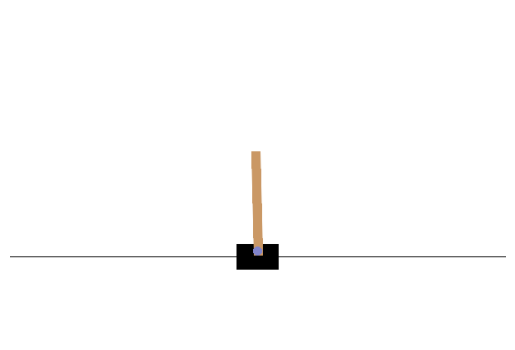

: 

In [ ]:
compute_avg_return(env, agent, num_episodes=10, render=True)
env.close()